In [1]:
%matplotlib inline

# Test normalization with toy simulation

To test the normalization, we simulate several bins of different sizes and distances from the DOM and make sure that the normalized result of the toy Retro sim matches the result from the forward simulation.

In [2]:
from __future__ import division, print_function

from copy import deepcopy
from itertools import product
from os.path import expanduser, expandvars, join
import sys
from time import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pisa import ureg
from pisa.core.binning import OneDimBinning

<< PISA is running in double precision (FP64) mode; numba is running on GPU >>


In [3]:
retro_dir = expanduser(expandvars('~/src/retro'))
if retro_dir not in sys.path:
    sys.path.append(retro_dir)

In [4]:
from retro import mkdir, powerspace, pol2cart
from retro.toy_sim import (
    sgnstar,
    pick_nonzero_bin,
    forward_survival_prob,
    retro_point_dom_survival_prob,
    retro_finite_dom_survival_prob
)

In [5]:
outdir = 'toy_sim_test_normalization'
mkdir(outdir)

Define physical constants and parameters

In [6]:
speed_of_light = 299792458 # m/s
absorption_length = 1 # m

Define binning for table

In [7]:
r_binning = OneDimBinning(
    name='r',
    bin_edges=powerspace(0, 25, 26, 1),
    units='m'
)
phi_binning = OneDimBinning(
    name='phi',
    tex=r'\phi',
    domain=(0, 2*np.pi),
    is_lin=True,
    num_bins=32,
    units='rad'
)
t_binning = OneDimBinning(
    name='t',
    domain=(0, 100),
    is_lin=True,
    num_bins=10,
    units='ns'
)
phidir_binning = OneDimBinning(
    name='phidir',
    tex=r'\phi_{\rm dir}',
    domain=(0, 2*np.pi),
    is_lin=True,
    num_bins=96,
    units='rad'
)
binning = r_binning * phi_binning * t_binning * phidir_binning
binning

MultiDimBinning([
    OneDimBinning('r', 25 equally-sized bins spanning [0.0, 25.0] m)),
    OneDimBinning('phi', 32 equally-sized bins spanning [0.0, 6.28318530718] rad)),
    OneDimBinning('t', 10 equally-sized bins spanning [0.0, 100.0] ns)),
    OneDimBinning('phidir', 96 equally-sized bins spanning [0.0, 6.28318530718] rad))])

Define the DOM (centered at origin)

In [8]:
dom_radius = 0.165 # m
dom_circumference = 2*np.pi * dom_radius # m
dom_area = np.pi * dom_radius**2 # m^2
dom_efficiency = 1.0 # perfect detector

Run the simulations.

In [9]:
%%time

n_photons = int(1e7)
step_length = 0.1
max_trials = np.inf
debug = False

fname_sfx = '{:.0e}_photons_{:f}_m_step_length'.format(n_photons, step_length)

results = []
trial = 0
for r_idx in range(binning.r.num_bins):
    try:
        bin0, bin_idx0 = pick_nonzero_bin(
            binning=binning,
            r_idx=r_idx,
            phi_idx=1,
            dom_radius=dom_radius,
            speed_of_light=speed_of_light
        )
    except:
        continue
    r_idx0, phi_idx0, t_idx0, phidir_idx0 = bin_idx0

    offsets = [-1, 0, 1]
    for phi_offset, t_offset, phidir_offset in product(*[offsets]*3):
        phi_idx = phi_idx0 + phi_offset
        if phi_idx < 0 or phi_idx > (binning.phi.num_bins - 1):
            continue
        t_idx = t_idx0 + t_offset
        if t_idx < 0 or t_idx > (binning.t.num_bins - 1):
            continue
        phidir_idx = phidir_idx0 + phidir_offset
        if phidir_idx < 0 or phidir_idx > (binning.phidir.num_bins - 1):
            continue
        bin_idx = r_idx, phi_idx, t_idx, phidir_idx
        bin = binning[bin_idx]
        #print(bin_idx)
        result = dict(r_idx=r_idx, phi_idx=phi_idx, t_idx=t_idx, phidir_idx=phidir_idx)
        
        result['r_wid'] = bin.r.bin_widths[0].m_as('m')
        result['phi_wid'] = bin.phi.bin_widths[0].m_as('deg')
        result['t_wid'] = bin.t.bin_widths[0].m_as('ns')
        result['phidir_wid'] = bin.phidir.bin_widths[0].m_as('deg')

        r_wid = bin.r.bin_widths[0].m_as('m')
        phi_wid = bin.phi.bin_widths[0].m_as('rad')
        t_wid = bin.t.bin_widths[0].m_as('ns')
        phidir_wid = bin.phidir.bin_widths[0].m_as('rad')
        
        result['r_edges'] = bin.r.bin_edges.m_as('m')
        result['r_mid'] = bin.r.midpoints[0].m_as('m')
        result['t_edges'] = bin.t.bin_edges.m_as('ns')
        result['phi_edges'] = bin.phi.bin_edges.m_as('deg')
        result['phidir_edges'] = bin.phidir.bin_edges.m_as('deg')
        
        t0 = time()
        fwd_pdet, fwd_num_hits = forward_survival_prob(
            absorption_length=absorption_length,
            binning=bin,
            n_photons=n_photons,
            dom_efficiency=dom_efficiency,
            dom_radius=dom_radius,
            speed_of_light=speed_of_light,
            seed=0
        )
        if debug: print('fwd:', time() - t0)
        result['fwd_pdet'] = fwd_pdet
        result['fwd_num_hits'] = fwd_num_hits
        
        t0 = time()
        pt_pdet_unnormed, pt_num_photons_in_bin, pt_num_counts = retro_point_dom_survival_prob(
            absorption_length=absorption_length,
            binning=bin,
            n_photons=n_photons,
            dom_efficiency=dom_efficiency,
            dom_radius=dom_radius,
            speed_of_light=speed_of_light,
            step_length=step_length,
            seed=0
        )
        if debug: print('pt:', time() - t0)
        result['pt_pdet_unnormed'] = pt_pdet_unnormed
        result['pt_num_photons_in_bin'] = pt_num_photons_in_bin
        
        t0 = time()
        fin_pdet_unnormed, fin_num_counts = retro_finite_dom_survival_prob(
            absorption_length=absorption_length,
            binning=bin,
            n_photons=n_photons,
            dom_efficiency=dom_efficiency,
            dom_radius=dom_radius,
            speed_of_light=speed_of_light,
            step_length=step_length,
            seed=0
        )
        if debug: print('fin:', time() - t0)
        result['fin_pdet_unnormed'] = float(fin_pdet_unnormed.squeeze())
        result['fin_num_counts'] = float(fin_num_counts.squeeze())

        results.append(result)
        trial += 1
        if trial >= max_trials:
            break
    if trial >= max_trials:
        break
    
results = pd.DataFrame(results)
results_df = results

fpath_base = join(outdir, 'toy_sim_results_' + fname_sfx)
results.to_csv(fpath_base + '.csv')
results.to_json(fpath_base + '.json')

CPU times: user 51min 7s, sys: 4min 42s, total: 55min 50s
Wall time: 55min 48s


In [10]:
cols = sorted(results.columns)

dims = ['r', 't', 'phi', 'phidir']
sims = ['fwd', 'pt', 'fin']
col_order = (
    [d + '_idx' for d in dims]
    + ['fwd_pdet', 'pt_pdet_unnormed', 'fin_pdet_unnormed']
    + ['fwd_num_hits', 'pt_num_photons_in_bin', 'pt_num_counts', 'fin_num_counts']
    + [d + '_edges' for d in dims]
    + [d + '_wid' for d in dims]
    + ['r_mid']
)
sort_cols = [c for c in col_order if 'edges' not in c]
summary = results[col_order].sort_values(by=sort_cols).reset_index(drop=True)

fpath_base = join(outdir, 'toy_sim_summary_' + fname_sfx)
summary.to_csv(fpath_base + '.csv')
summary.to_json(fpath_base + '.json')

summary

,r_idx,t_idx,phi_idx,phidir_idx,fwd_pdet,pt_pdet_unnormed,fin_pdet_unnormed,fwd_num_hits,pt_num_photons_in_bin,pt_num_counts,fin_num_counts,r_edges,t_edges,phi_edges,phidir_edges,r_wid,t_wid,phi_wid,phidir_wid,r_mid
0,0,0,0,51,5.647642e-01,0.000000,1.397168e+05,9075370,0,0,240927.0,"[0.0, 1.0]","[0.0, 10.0]","[0.0, 11.25]","[191.25, 195.0]",1.0,10.0,11.25,3.75,0.5
1,0,0,0,52,4.621532e-01,0.000000,1.355641e+05,7140826,0,0,229235.0,"[0.0, 1.0]","[0.0, 10.0]","[0.0, 11.25]","[195.0, 198.75]",1.0,10.0,11.25,3.75,0.5
2,0,0,0,53,3.331197e-01,0.000000,1.108858e+05,4742381,0,0,176803.0,"[0.0, 1.0]","[0.0, 10.0]","[0.0, 11.25]","[198.75, 202.5]",1.0,10.0,11.25,3.75,0.5
3,0,0,1,51,6.130836e-01,619323.396725,1.276060e+05,9961011,104360,939240,215486.0,"[0.0, 1.0]","[0.0, 10.0]","[11.25, 22.5]","[191.25, 195.0]",1.0,10.0,11.25,3.75,0.5
4,0,0,1,52,6.180308e-01,615908.698337,1.202639e+05,10000000,103785,934065,198645.0,"[0.0, 1.0]","[0.0, 10.0]","[11.25, 22.5]","[195.0, 198.75]",1.0,10.0,11.25,3.75,0.5
5,0,0,1,53,6.130874e-01,619471.493201,1.276419e+05,9961163,104385,939465,215591.0,"[0.0, 1.0]","[0.0, 10.0]","[11.25, 22.5]","[198.75, 202.5]",1.0,10.0,11.25,3.75,0.5
6,0,0,2,51,3.332194e-01,0.000000,1.104273e+05,4744105,0,0,176025.0,"[0.0, 1.0]","[0.0, 10.0]","[22.5, 33.75]","[191.25, 195.0]",1.0,10.0,11.25,3.75,0.5
7,0,0,2,52,4.621017e-01,0.000000,1.349569e+05,7139844,0,0,228203.0,"[0.0, 1.0]","[0.0, 10.0]","[22.5, 33.75]","[195.0, 198.75]",1.0,10.0,11.25,3.75,0.5
8,0,0,2,53,5.648072e-01,0.000000,1.414267e+05,9076251,0,0,244024.0,"[0.0, 1.0]","[0.0, 10.0]","[22.5, 33.75]","[198.75, 202.5]",1.0,10.0,11.25,3.75,0.5
9,0,1,0,51,0.000000e+00,0.000000,0.000000e+00,0,0,0,0.0,"[0.0, 1.0]","[10.0, 20.0]","[0.0, 11.25]","[191.25, 195.0]",1.0,10.0,11.25,3.75,0.5


In [11]:
multiplicity = summary.pt_num_counts / summary.pt_num_photons_in_bin
multiplicity[multiplicity > 0].describe()

count    75.0
mean      9.0
std       0.0
min       9.0
25%       9.0
50%       9.0
75%       9.0
max       9.0
dtype: float64

In [12]:
t_width_m = summary.t_wid * 1e-9 * speed_of_light

pt_limiting_bin_width = deepcopy(summary.r_wid)
mask = t_width_m < summary.r_wid
pt_limiting_bin_width[mask] = t_width_m[mask]
print('(pt) Fraction of bins where radial length limits multi-counting:', (1 - np.sum(mask) / len(mask)))

fin_effective_r_width = deepcopy(summary.r_wid)
fin_effective_r_width[summary.r_idx == 0] = summary[summary.r_idx == 0].r_wid - dom_radius
fin_effective_r_mid = deepcopy(summary.r_mid)
fin_effective_r_mid[summary.r_idx == 0] = ((1 - dom_radius) + 1) / 2

fin_limiting_bin_width = deepcopy(fin_effective_r_width)
mask = t_width_m < fin_effective_r_width
fin_limiting_bin_width[mask] = t_width_m[mask]
print('(fin) Fraction of bins where radial length limits multi-counting:', (1 - np.sum(mask) / len(mask)))

(pt) Fraction of bins where radial length limits multi-counting: 1.0
(fin) Fraction of bins where radial length limits multi-counting: 1.0


Each photon would live forever (if no absorption) so size of time bin is irrelevant for how photons are distributed.
As the photon is timeless, it also will live for all radii and is not divided by this parameter.

On the other hand, it does take on just one direction chosen from 2$\pi$ and will occupy one angular coordinate in the the 2$\pi$ circle.
As the photons spread out from their source, they will occupy a part of the circle that is less than the portion occupied at the start, with proportionality $\propto r^{-1}$.

Each photon will be counted every `stepLength` distance along its path, which leads to multiple-counting in each bin due to whichever of the bin's $\{t, r\}$ dimension is smaller.

In [13]:
# photons_per_bin = n_photons / binning.phi.num_bins / binning.phidir.num_bins

# pt_counts_per_photon = np.clip(pt_limiting_bin_width / step_length - 1, 0, np.inf)
# fin_counts_per_photon = np.clip(fin_limiting_bin_width / step_length - 1, 0, np.inf)

# pt_counts_per_bin = photons_per_bin * pt_counts_per_photon
# fin_counts_per_bin = photons_per_bin * fin_counts_per_photon

# pt_norm = 1 / pt_counts_per_bin / summary.r_mid
# fin_norm = 1 / fin_counts_per_bin / summary.r_mid

# pt_pdet = summary.pt_pdet_unnormed * pt_norm
# fin_pdet = summary.fin_pdet_unnormed * fin_norm
# summary['pt_pdet'] = pt_pdet
# summary['fin_pdet'] = fin_pdet

Normalize by taking the ratio of the "fluxes" out of the DOM / into the cell (i.e. normalize by bin circumference).

Note that the 1/r_mid factor is... dunno...

In [14]:
# summary_r_edges = np.array(summary.r_edges.values.tolist())

# pt_pdet = (
#     summary.pt_pdet_unnormed / (1 * (pt_limiting_bin_width / step_length))
#     * (2*np.pi * dom_radius) / (2*summary.r_wid + np.deg2rad(summary.phi_wid) * np.sum(summary_r_edges, axis=1))
#     / summary.r_mid#**0.5
# )
# fin_pdet = (
#     summary.fin_pdet_unnormed / (1 * (fin_limiting_bin_width / step_length))
#     * (2*np.pi * dom_radius) / (2*summary.r_wid + np.deg2rad(summary.phi_wid) * np.sum(summary_r_edges, axis=1))
#     / summary.r_mid#**0.5
# )

# summary['pt_pdet'] = pt_pdet
# summary['fin_pdet'] = fin_pdet

## Simulation (table generation)

### Effective area via its definition

The effective area of a bin can be stated as the effective area of the "receiver" in the equation (https://en.wikipedia.org/wiki/Antenna_aperture)

$$A_r = {P_0 \over {\rm PFD}}$$

where $P_0$ is the power received (recorded in the bin) and PFD is the power flux density, e.g. in units of ${\rm W \cdot m^{-2}}$.
Since we are using counts rather than counts per second, I'll directly interpret "power" (photons per second) as "energy" (photons).

$P_0$ should be equivalent in our case to the number of photons recorded in the bin.
Since we don't record photons but _counts_ (photons tabulated every `stepLength` meters) instead, we have to convert the number recorded in a bin to photons via

$$P_0 = {\rm number\,of\,photons\,in\,bin} = \sum_{{\rm photon}\,i=1}^{I} \left( \frac{1}{J_i} \cdot \sum_{{\rm step}\,j=1}^{J_i} p_{ij} \right)$$

where $p_{ij}$ is the survival probability for the $i^{\rm th}$ photon at step $j$ and should incorporate any Monte Carlo weighting already (though I believe that since we sample directly from the pertinent angular and wavelength distributions, each photon should have a Monte Carlo weight of 1 to start and then the overall table simply needs to be scaled by the scalar quantum efficiency $\times$ angular acceptance factors in the end.

Here we have to be careful since the number of times we count the $i^{\rm th}$ photon in the bin (denoted by  $J_i$) will, on average (and making the simplifying assumption that the photon moves radially through the spherical-polar-coordinates bin), be determined by the smaller of the temporal and radial extents of the bin (where these can be compared via the speed of the photon).
So making these assumptions about the direction of the photons in the bin all being radial and picking the appropriate limiting dimension with which to compute this, all $J_i$ are the same and we'll call this just $J$.
This factor then can come out of the sum over the photons in the bin, so $P_0$ is

$$P_0 = \frac{1}{J} \cdot \sum_{{\rm photon}\,i=1}^{I} \sum_{{\rm step}\,j=1}^{J_i} p_{ij}$$

and the CLSim tabulator gives us the result of the two sums, we just have to compute $J$.

Note that a "better" tabulator would perform the more precise calculation above (average probabilities over a single photon and _then_ sum those average probabilities to get the expected number of photons in the bin).
Also, for quantifying uncertainties, a "better" tabulator would record $I$, the number of "unique" photons in the bin.

PFD should, in our case, be equivalent to

$${\rm PFD} = \frac{\rm flux\,at\,bin}{\rm bin\,cross\,section} = \frac{N_{\gamma, {\rm source}} \cdot (\Omega_{\rm bin}/4\pi)}{ d^2 \cdot \Omega_{\rm bin} } = \frac{ N_{\gamma, {\rm source}} }{ 4\pi \cdot d^2 }$$

where we pick $d$ to be the weighted average bin radius (i.e., distance to the bin's center of mass) which in 2D and 3D is

$$d_{\rm 2D} = \frac{2}{3} \cdot \frac{\Delta(r_{\rm bin}^3)}{\Delta(r_{\rm bin}^2)}$$
$$d_{\rm 3D} = \frac{3}{4} \cdot \frac{\Delta(r_{\rm bin}^4)}{\Delta(r_{\rm bin}^3)}$$

and we consider the flux at the bin as if no scattering were to occur (the scattering in the medium, for us, counts as being part of the "receive antenna's" (bin's) characteristics and _not_ as being a part of some medium in which the "antenna" sits.
I.e., the medium _is_ the antenna in our case.

Thus, the effective area equation becomes

$$A_r = {P_0 \over {\rm PFD}} = \frac{ 4\pi P_0 d^2 }{ N_{\gamma,{\rm source}} }$$

### Effective area via the Friis transmission equation with isotropic radiator

The Friis transmission formula is (https://en.wikipedia.org/wiki/Friis_transmission_equation)

$${P_r \over P_t} = \frac{A_r A_t}{d^2 \lambda^2}.$$

For table-building with the "point DOM," we use an isotropic source

$$A_t = {\rm isotropic} = {\lambda^2 \over 4\pi}$$

so the Friis formula becomes

$${P_r \over P_t} = \frac{ A_r }{ 4\pi d^2 }$$

and solving for the "receiver's" (the bin is the receiver in this case) effective area,

$$A_r = { 4\pi P_r d^2 \over P_t}$$

The received power is the the same as $P_0$ above

$$P_r = P_0 = \frac{1}{J} \cdot \sum_{{\rm photon}\,i=1}^{I} \sum_{{\rm step}\,j=1}^{J_i} p_{ij}$$

and the transmitted power is simply the number of photons

$$P_t = N_{\gamma,{\rm source}}$$

which yields

$$A_r = \frac{ 4\pi P_0 d^2 }{ N_{\gamma,{\rm source}} }$$

and so we obtain the same effective area for the bin with both approaches.

## Reconstruction (using the tables)

If the above all works out, then we now have a value for the effective area of each bin.

In order to compute how much light will make it from the bin back to the DOM, we then have to go back to the Friis transmission equation:

$${P_r} = P_t \frac{A_r A_t}{d^2 \lambda^2}.$$

where now the receiver is the DOM and the transmitter is _in_ the bin (but is _not_ the bin, just some fraction of the bin) and $A_r$ is the DOM's effective area.

The 60 k\$ question is _what_ is the effective area of the transmitter in this case?
Maybe we can assume it's a source with directivity given by the angular bin size $\Omega_{\rm dir, bin}$, but with no extent.
Or maybe it's a "perfect" line source with no extent but perfect directionality; and in this case, we'd expect we'd need to use stick with the density.

In our toy 2D simulation, the DOM is assumed to be a "perfect" radiator/detector in all directions (i.e. is isotropic), which means $A_r = \lambda^2 / 4\pi$.

We could at this point easily include the quantum efficiency and angular acceptance constant factors as reductions to $A_r$.
One could also use a more realistic effective area for the DOM at this point, but I'll leave that for later; let's just go with an isotropic with constant attenuation at all angles/wavelengths.

$$A_r = \lambda^2 / 4\pi$$

$d$ is treated the same as in the discussion above (i.e. the distance from the center of the DOM to the center of mass of the cell) and the powers in the Friis formula can be converted to photon counts, giving

$$ N_{\rm DOM} = N_{\rm emitter} \frac{ \frac{ \lambda^2 }{ 4\pi } \cdot \frac{ 4\pi N_{\rm bin} d^2 }{ N_{\gamma,{\rm source}} } }{ d^2 \lambda^2 }  = N_{\rm emitter} \frac{ N_{\rm bin} }{ N_{\gamma,{\rm source}} } $$

(modulo the quantum efficiency and angular acceptance scalars I note above that need to scale the effective areas down further).

How do we actually use this?

In [145]:
summary_r_edges = np.array(summary.r_edges.values.tolist())
r0 = summary_r_edges[:, 0]
r1 = summary_r_edges[:, 1]
r_cm = 2/3*(r1**3 - r0**3)/(r1**2 - r0**2)

pt_pdet = (
    summary.pt_pdet_unnormed
    / (n_photons / binning.phi.num_bins * np.clip(np.floor(pt_limiting_bin_width / step_length - 1), 0, np.inf))
    / (np.deg2rad(summary.phi_wid) * r_cm)
)
fin_pdet = (
    summary.fin_pdet_unnormed
    / (n_photons / binning.phi.num_bins * np.clip(np.floor(fin_limiting_bin_width / step_length - 1), 0, np.inf))
    / (np.deg2rad(summary.phi_wid) * r_cm)
)

summary['pt_pdet'] = pt_pdet
summary['fin_pdet'] = fin_pdet

In [146]:
cols = sorted(results.columns)

dims = ['r', 't', 'phi', 'phidir']
sims = ['fwd', 'pt', 'fin']
col_order = (
    [d + '_idx' for d in dims]
    + ['fwd_pdet', 'pt_pdet', 'fin_pdet', 'pt_pdet_unnormed', 'fin_pdet_unnormed']
    + ['fwd_num_hits', 'pt_num_photons_in_bin', 'pt_num_counts', 'fin_num_counts']
    + [d + '_edges' for d in dims]
    + [d + '_wid' for d in dims]
    + ['r_mid']
)
sort_cols = [c for c in col_order if 'edges' not in c]
summary = summary[col_order].sort_values(by=sort_cols).reset_index(drop=True)

fpath_base = join(outdir, 'toy_sim_summary_' + fname_sfx)
summary.to_csv(fpath_base + '.csv')
summary.to_json(fpath_base + '.json')

summary[[c for c in col_order if ('edges' not in c and 'wid' not in c and 'unnormed' not in c)]]

,r_idx,t_idx,phi_idx,phidir_idx,fwd_pdet,pt_pdet,fin_pdet,fwd_num_hits,pt_num_photons_in_bin,pt_num_counts,fin_num_counts,r_mid
0,0,0,0,51,5.647642e-01,0.000000e+00,4.879348e-01,9075370,0,0,240927.0,0.5
1,0,0,0,52,4.621532e-01,0.000000e+00,4.734324e-01,7140826,0,0,229235.0,0.5
2,0,0,0,53,3.331197e-01,0.000000e+00,3.872480e-01,4742381,0,0,176803.0,0.5
3,0,0,1,51,6.130836e-01,1.682234e+00,4.456404e-01,9961011,104360,939240,215486.0,0.5
4,0,0,1,52,6.180308e-01,1.672959e+00,4.199993e-01,10000000,103785,934065,198645.0,0.5
5,0,0,1,53,6.130874e-01,1.682636e+00,4.457657e-01,9961163,104385,939465,215591.0,0.5
6,0,0,2,51,3.332194e-01,0.000000e+00,3.856467e-01,4744105,0,0,176025.0,0.5
7,0,0,2,52,4.621017e-01,0.000000e+00,4.713120e-01,7139844,0,0,228203.0,0.5
8,0,0,2,53,5.648072e-01,0.000000e+00,4.939065e-01,9076251,0,0,244024.0,0.5
9,0,1,0,51,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0.0,0.5


The following is _wrong_ due to the `np.sum(binning.r.bin_edges.m_as('m')` bit ... and I can't explain why we don't use n_photons or why the 1/r_mid factor needs to be here.

In [147]:
# summary_r_edges = np.array(summary.r_edges.values.tolist())

# pt_pdet = (
#     summary.pt_pdet_unnormed / (1 * (pt_limiting_bin_width / step_length - 1))
#     * (2*np.pi * dom_radius) / (2*summary.r_wid + np.deg2rad(summary.phi_wid) * np.sum(binning.r.bin_edges.m_as('m')))
#     / summary.r_mid
# )
# fin_pdet = (
#     summary.fin_pdet_unnormed / (1 * (fin_limiting_bin_width / step_length - 1))
#     * (2*np.pi * dom_radius) / (2*summary.r_wid + np.deg2rad(summary.phi_wid) * np.sum(binning.r.bin_edges.m_as('m')))
#     / summary.r_mid
# )

# summary['pt_pdet'] = pt_pdet
# summary['fin_pdet'] = fin_pdet

In [148]:
# pt_pdet_n = (summary.pt_pdet_unnormed / summary.pt_num_hits) * (2*np.pi * dom_radius) / (2*summary.r_wid + np.deg2rad(summary.phi_wid) * np.sum(summary_r_edges, axis=1)) / summary.r_mid
# print((pt_pdet_n / summary.fwd_pdet).describe())
# fin_pdet_n = (summary.fin_pdet_unnormed / summary.fin_num_hits) * (2*np.pi * dom_radius) / (2*summary.r_wid + np.deg2rad(summary.phi_wid) * np.sum(summary_r_edges, axis=1)) / summary.r_mid
# print((fin_pdet_n / summary.fwd_pdet).describe())

Normalize by taking the ratio of the areas (bin hyper-volume... in this case, since it's 2D, that's just area).

In [149]:
# pt_pdet = (
#     summary.pt_pdet_unnormed / (pt_limiting_bin_width / step_length) * (np.pi * dom_radius**2) / np.abs(0.5 * np.diff(summary.r_edges**2)[0] * np.diff(summary.phi_edges, axis=1))
# )
# fin_pdet = (
#     summary.fin_pdet_unnormed / (fin_limiting_bin_width / step_length) * (np.pi * dom_radius**2) / np.abs(0.5 * np.diff(summary.r_edges**2)[0] * np.diff(summary.phi_edges)[0])
# )

# summary['pt_pdet'] = pt_pdet
# summary['fin_pdet'] = fin_pdet

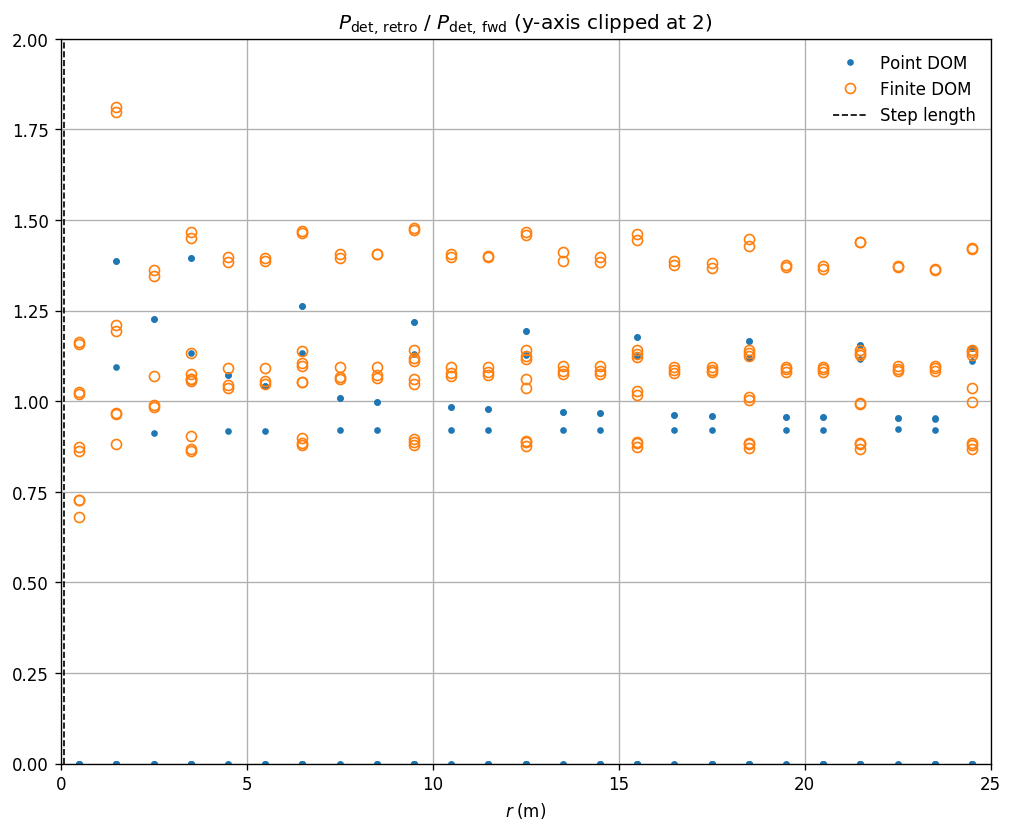

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=120)
ax.plot(
    summary.r_mid, (summary.pt_pdet / summary.fwd_pdet),
    '.', 
    label='Point DOM'
)
ax.plot(
    summary.r_mid, (summary.fin_pdet / summary.fwd_pdet),
    'o', mfc='none',
    label='Finite DOM'
)

ylim = [0, ax.get_ylim()[1]]
xlim = [0, 25]
ax.plot([step_length]*2, [0, ylim[1]], 'k--', lw=1, label='Step length')

ax.set_title(r'${P}_{\rm det,\, retro}$ / ${P}_{\rm det,\, fwd}$ (y-axis clipped at 2)')
ax.legend(loc='best', frameon=False)
ax.set_xlabel('${}$'.format(binning.r.label))
ax.set_xlim(xlim)
ax.set_ylim([0,2])
ax.grid(b=True, which='major')

fpath_base = join(outdir, 'pdet_retro_divby_pdet_fwd_zoom_' + fname_sfx)
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

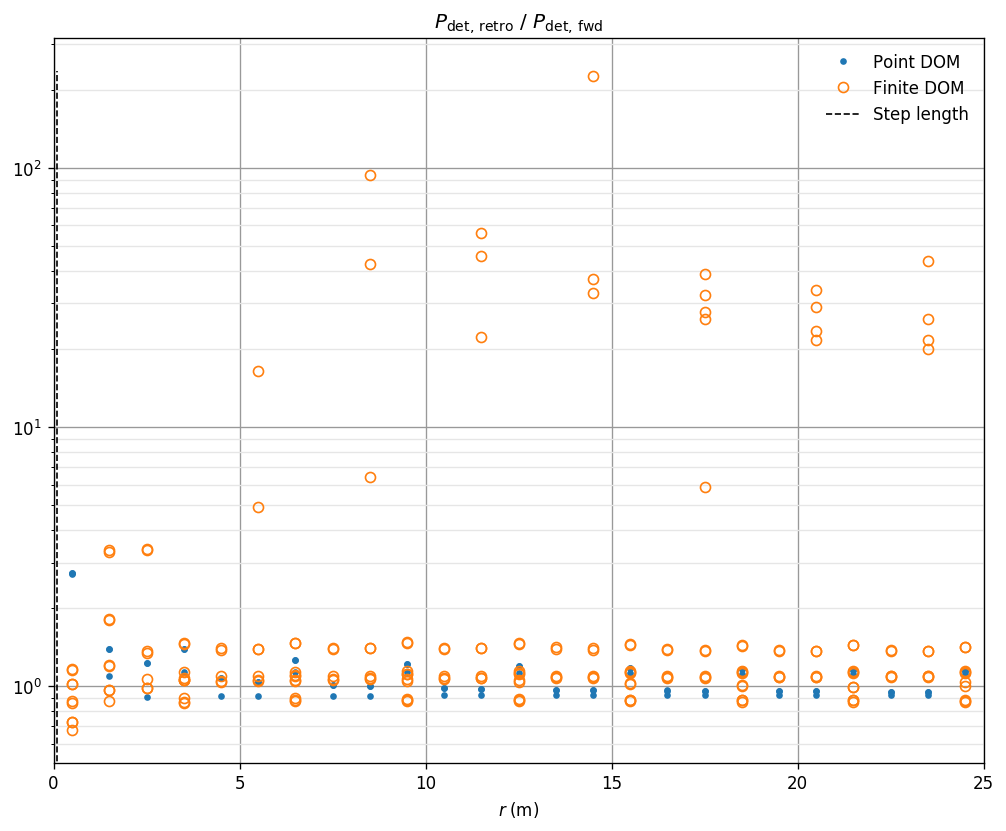

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=120)
ax.plot(
    summary.r_mid, (summary.pt_pdet / summary.fwd_pdet),
    '.', 
    label='Point DOM'
)
ax.plot(
    summary.r_mid, (summary.fin_pdet / summary.fwd_pdet),
    'o', mfc='none',
    label='Finite DOM'
)
ylim = [0, ax.get_ylim()[1]]
xlim = [0, 25]
ax.plot([step_length]*2, [0, ylim[1]], 'k--', lw=1, label='Step length')

ax.set_title(r'${P}_{\rm det,\, retro}$ / ${P}_{\rm det,\, fwd}$')
ax.legend(loc='best', frameon=False)
ax.set_xlabel('${}$'.format(binning.r.label))
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.grid(b=True, which='major', color=[0.6]*3)
ax.grid(b=True, which='minor', color=[0.9]*3)

fpath_base = join(outdir, 'pdet_retro_divby_pdet_fwd_logy_' + fname_sfx)
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

In [152]:
large_r = summary.query('r_mid >= 4.5')
pt_pdet_ratio = (large_r.pt_pdet / large_r.fwd_pdet)
avg_pt_pdet_ratio = pt_pdet_ratio[pt_pdet_ratio > 0].mean()
print(' avg pt pdet / fwd pdet, r_mid >= 4.5 m (for nonzero bins only): %.4f = 1 / %.4f' % (avg_pt_pdet_ratio, 1 / avg_pt_pdet_ratio))

fin_pdet_ratio = (large_r.fin_pdet / large_r.fwd_pdet)
avg_fin_pdet_ratio = fin_pdet_ratio[pt_pdet_ratio > 0].mean()
print('avg fin pdet / fwd pdet, r_mid >= 4.5 m (for nonzero bins only): %.4f = 1 / %.4f' % (avg_fin_pdet_ratio, 1/avg_fin_pdet_ratio))

 avg pt pdet / fwd pdet, r_mid >= 4.5 m (for nonzero bins only): 1.0306 = 1 / 0.9703
avg fin pdet / fwd pdet, r_mid >= 4.5 m (for nonzero bins only): 1.0971 = 1 / 0.9115


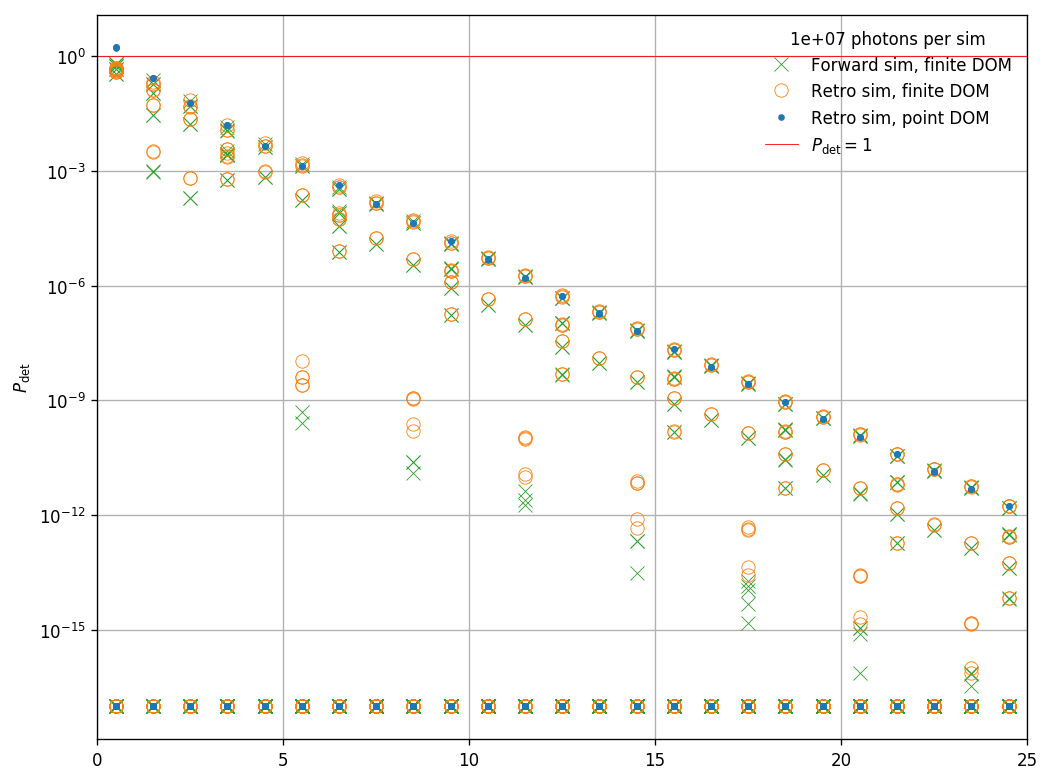

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=120)

a_min = 1e-17

ax.plot(
    summary.r_mid, np.clip(summary.fwd_pdet, a_min, np.inf),
    'x', color='C2', ms=8, mew=0.5,
    label='Forward sim, finite DOM'
)
ax.plot(
    summary.r_mid, np.clip(summary.fin_pdet, a_min, np.inf),
    'o', mfc='none', mec='C1', mew=0.5, ms=8,
    label='Retro sim, finite DOM'
)
ax.plot(
    summary.r_mid, np.clip(summary.pt_pdet, a_min, np.inf),
    '.',  color='C0',
    label='Retro sim, point DOM'
)
xlim = [0, 25]
ax.plot([0, xlim[1]], [1,1], 'r-', lw=0.5, label=r'$P_{\rm det}=1$')

ylim = [0, ax.get_ylim()[1]]
ax.set_ylabel(r'${P}_{\rm det}$')
ax.legend(
    loc='best',
    frameon=False,
    title='{:.0e} photons per sim'.format(n_photons)
)
#ax.set_xlabel('${}$'.format(binning.r.label))
ax.set_xlim(0, xlim[1])
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.grid(which='major', b=True)
ax.grid(which='minor', b=True)

fpath_base = join(outdir, 'pdet_retro_and_pdet_fwd_logy_' + fname_sfx)
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

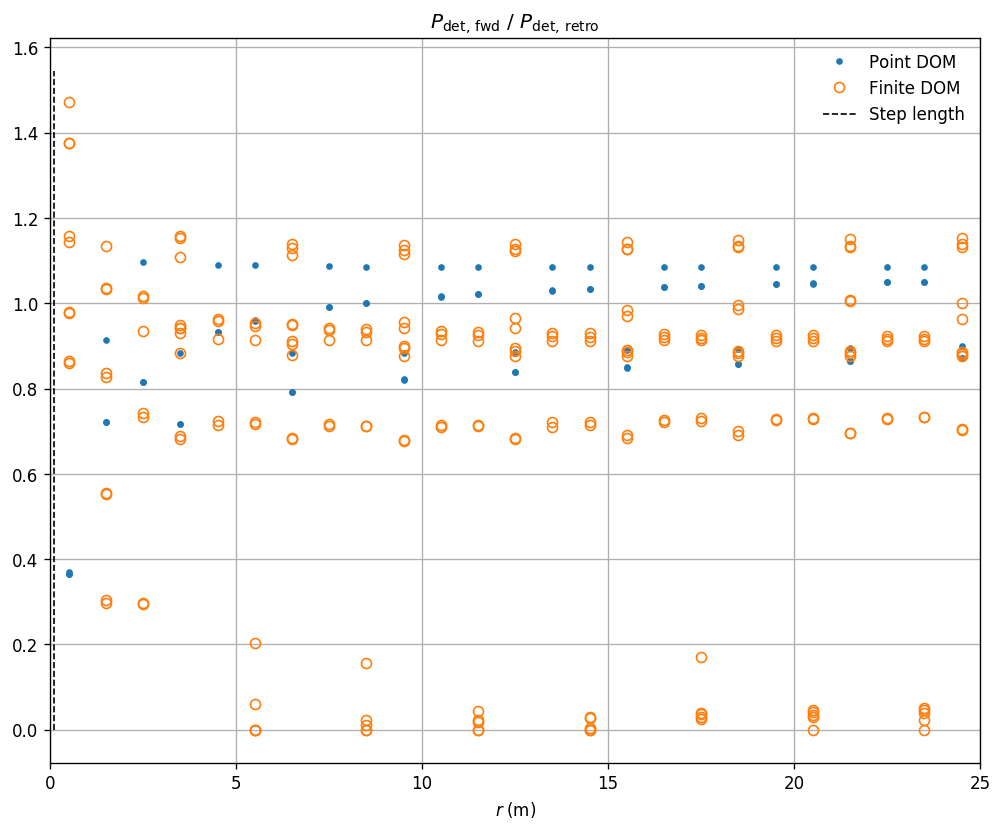

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=120)
ax.plot(
    summary.r_mid, 1/(summary.pt_pdet / summary.fwd_pdet),
    '.', 
    label='Point DOM'
)
ax.plot(
    summary.r_mid, 1/(summary.fin_pdet / summary.fwd_pdet),
    'o', mfc='none',
    label='Finite DOM'
)
ylim = [0, ax.get_ylim()[1]]
xlim = [0, 25]
ax.plot([step_length]*2, [0, ylim[1]], 'k--', lw=1, label='Step length')
ax.set_title(r'${P}_{\rm det,\, fwd}$ / ${P}_{\rm det,\, retro}$')
ax.legend(loc='best', frameon=False)
ax.set_xlabel('${}$'.format(binning.r.label))
ax.set_xlim(xlim)
ax.grid(b=True, which='major')

fpath_base = join(outdir, 'pdet_fwd_divby_pdet_retro_' + fname_sfx)
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

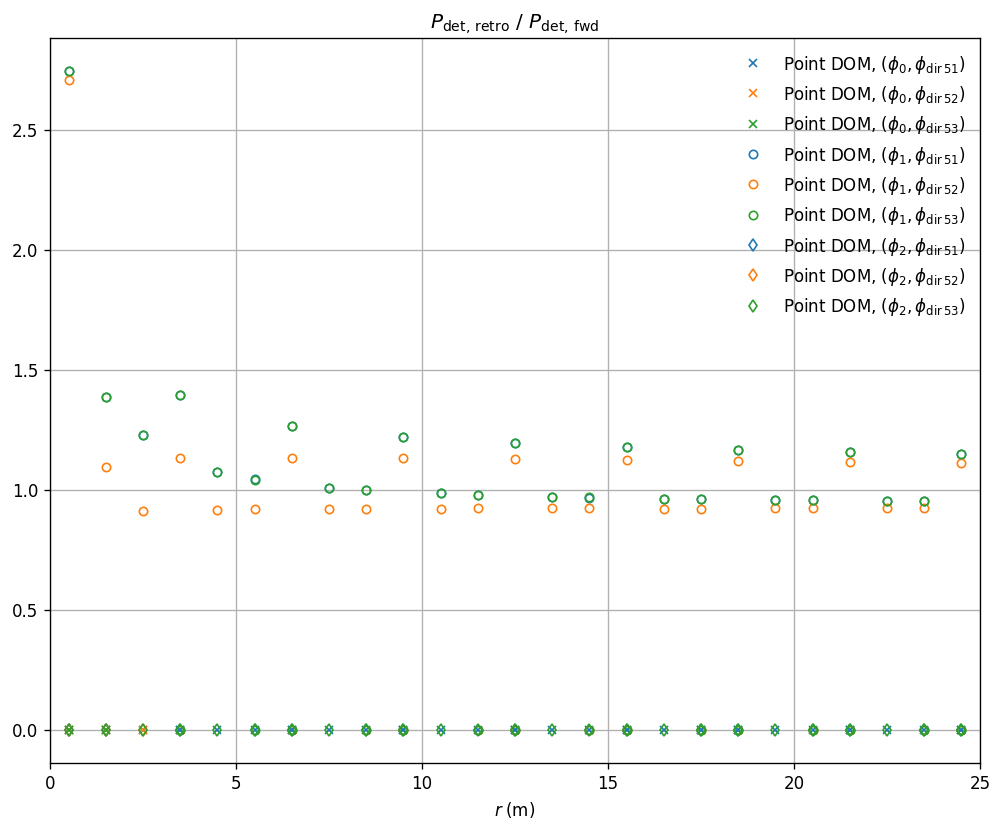

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=120)
for phi_idx, phidir_idx in product(summary.phi_idx.unique(), summary.phidir_idx.unique()):
    s = summary.query('(phi_idx == @phi_idx) & (phidir_idx == @phidir_idx)')
    label = r'Point DOM, $(\phi_{%d}, \phi_{\rm dir \, %d})$' % (phi_idx, phidir_idx)
    if phi_idx == 0:
        marker = 'x'
    elif phi_idx == 1:
        marker = 'o'
    elif phi_idx == 2:
        marker = 'd'
    if phidir_idx == 51:
        color = 'C0'
    elif phidir_idx == 52:
        color = 'C1'
    elif phidir_idx == 53:
        color = 'C2'
        
    ax.plot(
        s.r_mid.values, s.pt_pdet / s.fwd_pdet,
        marker=marker, linestyle='none', mew=1, ms=5, color=color, mfc='none', alpha=1,
        label=label
    )
ylim = [0, ax.get_ylim()[1]]
xlim = [0, 25]
ax.set_title(r'${P}_{\rm det,\, retro}$ / ${P}_{\rm det,\, fwd}$')
ax.legend(loc='best', frameon=False)
ax.set_xlabel('${}$'.format(binning.r.label))
ax.set_xlim(xlim)
ax.grid(b=True, which='major')

fpath_base = join(outdir, 'pdet_retro_pt_divby_pdet_fwd_phi_phidir_' + fname_sfx)
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

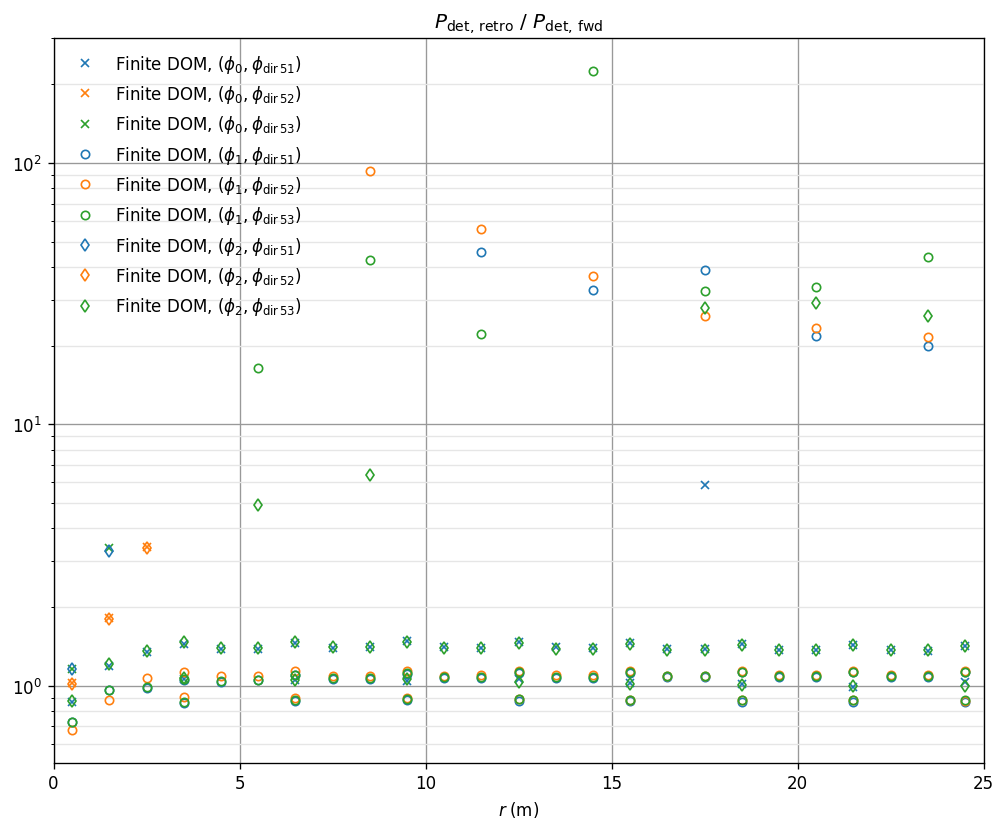

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=120)
for phi_idx, phidir_idx in product(summary.phi_idx.unique(), summary.phidir_idx.unique()):
    s = summary.query('(phi_idx == @phi_idx) & (phidir_idx == @phidir_idx)')
    label = r'Finite DOM, $(\phi_{%d}, \phi_{\rm dir \, %d})$' % (phi_idx, phidir_idx)
    if phi_idx == 0:
        #continue
        marker = 'x'
    elif phi_idx == 1:
        marker = 'o'
    elif phi_idx == 2:
        #continue
        marker = 'd'
    if phidir_idx == 51:
        #continue
        color = 'C0'
    elif phidir_idx == 52:
        color = 'C1'
    elif phidir_idx == 53:
        #continue
        color = 'C2'
        
    ax.plot(
        s.r_mid.values, s.fin_pdet / s.fwd_pdet,
        marker=marker, linestyle='none', mew=1, ms=5, color=color, mfc='none', alpha=1,
        label=label
    )
ylim = [0, ax.get_ylim()[1]]
xlim = [0, 25]

ax.set_title(r'${P}_{\rm det,\, retro}$ / ${P}_{\rm det,\, fwd}$')
ax.legend(loc='best', frameon=False)
ax.set_xlabel('${}$'.format(binning.r.label))
ax.set_xlim(xlim)
#ax.set_ylim([0, 2])
ax.set_yscale('log')
ax.grid(b=True, which='major', color=[0.6]*3)
ax.grid(b=True, which='minor', color=[0.9]*3)

fpath_base = join(outdir, 'pdet_retro_fin_divby_pdet_fwd_phi_phidir_logy_' + fname_sfx)
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass